In [2]:
# !pip install -q transformers

In [3]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [4]:
from PIL import Image
import requests

# url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
# image = Image.open(requests.get(url, stream=True).raw)
# image

In [17]:
import pandas as pd 

main_path = "/root/Master_Thesis/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"
expirements_path = main_path+"expirements/"
example_1_path = main_path + "GitHub/Active-Learning-Segmentation/prompt_examples/CLIP/Tumor_1_EX.png"
example_2_path = main_path + "GitHub/Active-Learning-Segmentation/prompt_examples/CLIP/Tumor_2_EX.png"
example_3_path = main_path + "GitHub/Active-Learning-Segmentation/prompt_examples/CLIP/Tumor_3_EX.png"

df = pd.read_csv(dataframes_path+"brain_df_train.csv")

In [6]:
# import gdown
# url = "https://drive.google.com/file/d/1hBiUe6bAY7kKQ9bjO9r19ZPjFn2bxeAy/view?usp=sharing"
# gdown.download(url, example_path, fuzzy=True, quiet=False)

In [7]:
import os
if os.path.isfile(example_3_path):
    print(True)

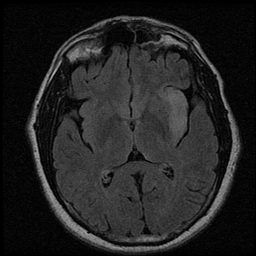

In [8]:
# i = 1, 5
i=5
image = Image.open(df["images"][i])
image

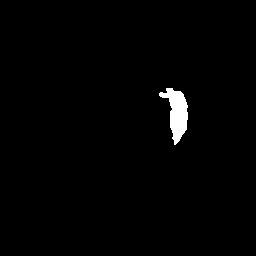

In [9]:
mask = Image.open(df["masks"][i])
mask

In [10]:
prompts = ["tumor", "cancer", "brain", "background"]

import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

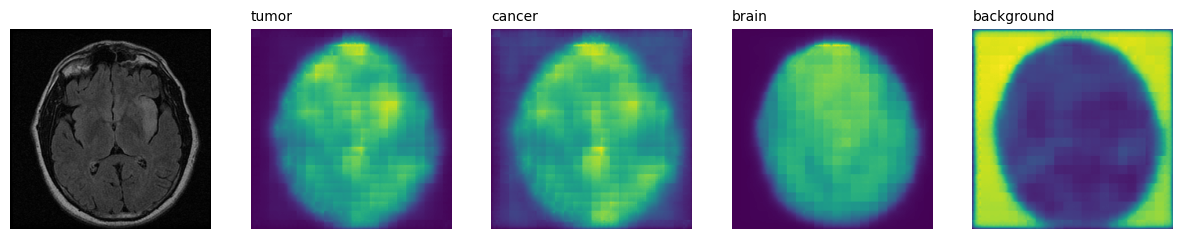

In [11]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

In [12]:
oracle_mask_0 = preds[0].squeeze().cpu()
oracle_mask_0 = (oracle_mask_0 - oracle_mask_0.min())/(oracle_mask_0.max() - oracle_mask_0.min())
oracle_mask_0 = (oracle_mask_0 > 0.95).float()

In [13]:
oracle_mask_1 = preds[1].squeeze().cpu()
oracle_mask_1 = (oracle_mask_1 - oracle_mask_1.min())/(oracle_mask_1.max() - oracle_mask_1.min())
oracle_mask_1 = (oracle_mask_1 > 0.95).float()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


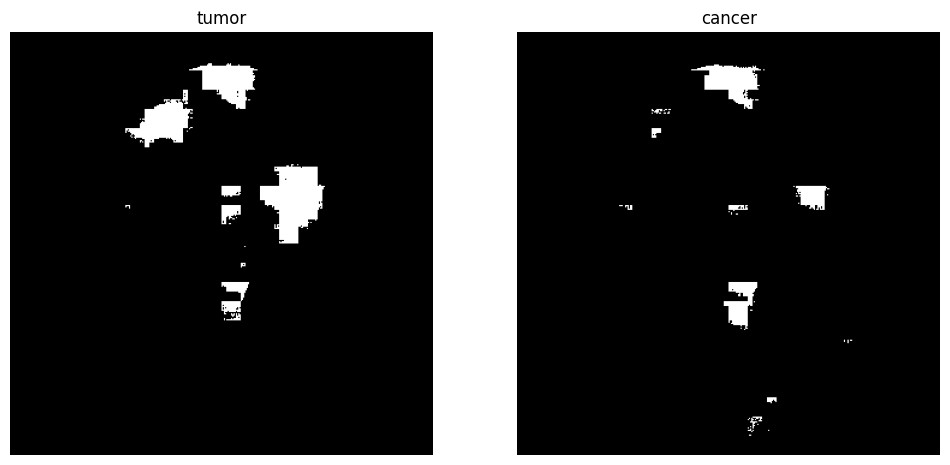

In [14]:
import supervision as sv

sv.plot_images_grid(
    images=[oracle_mask_0, oracle_mask_1],
    grid_size=(1, 2),
    titles=['tumor', 'cancer']
)   

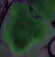

In [32]:
ex_1 = Image.open(example_1_path).convert("RGB")
ex_2 = Image.open(example_2_path).convert("RGB")
ex_3 = Image.open(example_3_path).convert("RGB")
prompts = [ex_1, ex_2, ex_3]
prompts[0]

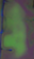

In [30]:
ex_2

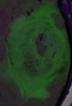

In [31]:
ex_3

In [19]:
import torch 
encoded_image = processor(images=[image, image, image], return_tensors="pt")
encoded_prompt = processor(images=prompts, return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

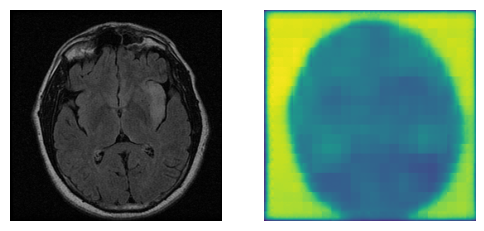

In [20]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0][0]))

In [26]:
oracle_mask_0 = preds[0][0].squeeze().cpu()
oracle_mask_0 = (oracle_mask_0 - oracle_mask_0.min())/(oracle_mask_0.max() - oracle_mask_0.min())
oracle_mask_0 = (oracle_mask_0 > 0.6).float()

In [27]:
oracle_mask_1 = preds[0][1].squeeze().cpu()
oracle_mask_1 = (oracle_mask_1 - oracle_mask_1.min())/(oracle_mask_1.max() - oracle_mask_1.min())
oracle_mask_1 = (oracle_mask_1 > 0.6).float()

In [28]:
oracle_mask_2 = preds[0][2].squeeze().cpu()
oracle_mask_2 = (oracle_mask_2 - oracle_mask_2.min())/(oracle_mask_2.max() - oracle_mask_2.min())
oracle_mask_2 = (oracle_mask_2 > 0.6).float()

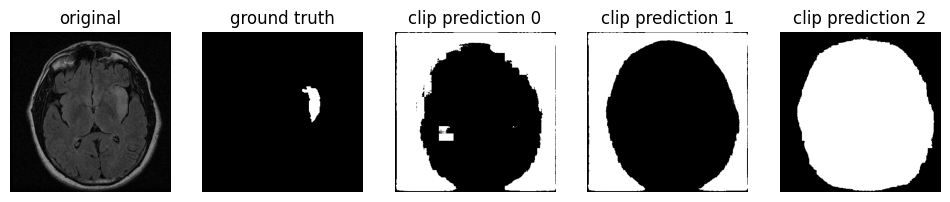

In [29]:
import supervision as sv
import cv2
image = cv2.imread(df["images"][i])
gt_mask = cv2.imread(df["masks"][i])

sv.plot_images_grid(
    images=[image, gt_mask, oracle_mask_0, oracle_mask_1, oracle_mask_2],
    grid_size=(1, 5),
    titles=['original',"ground truth" ,'clip prediction 0', 'clip prediction 1', 'clip prediction 2']
)   